<a href="https://colab.research.google.com/github/chauhanneha16/Audio_Spoofing/blob/main/Copy_of_spoofing_transformer%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d awsaf49/asvpoof-2019-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/asvpoof-2019-dataset
License(s): ODC Attribution License (ODC-By)
100% 23.6G/23.6G [22:07<00:00, 22.7MB/s]
100% 23.6G/23.6G [22:07<00:00, 19.1MB/s]


In [ ]:
%env KAGGLE_CONFIG_DIR=/root/.kaggle/

env: KAGGLE_CONFIG_DIR=/root/.kaggle/


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/asvpoof-2019-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf


In [ ]:
# Define paths and parameters
DATASET_PATH = "/content/LA/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH = "/content/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [ ]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [ ]:
X = np.array(X)
y = np.array(y)

X,y

(array([[[-78.88214 , -80.      , -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-71.71661 , -77.353325, -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-57.14656 , -59.50205 , -57.573334, ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [-69.18776 , -63.819817, -67.85419 , ...,   0.      ,
            0.      ,   0.      ],
         [-70.22391 , -64.85324 , -68.70045 , ...,   0.      ,
            0.      ,   0.      ],
         [-72.25124 , -66.18086 , -68.856   , ...,   0.      ,
            0.      ,   0.      ]],
 
        [[-72.254776, -78.77455 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-69.887405, -76.79361 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-57.00554 , -52.203255, -48.832603, ..., -73.142075,
          -71.93824 , -75.95265 ],
         ...,
         [-80.      , -68.084435, -64.63213 , ..., -47.64021 ,
          -42.370796, -4

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# ... (existing code)

y_encoded = to_categorical(y, NUM_CLASSES)

In [ ]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [ ]:
# Define test set from remaining data
X_test, y_test = X[split_index:], y_encoded[split_index:]


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv1D, MaxPooling1D

# Define Transformer and CNN model architecture
input_shape = (N_MELS, max_time_steps)  # Input shape for Transformer (time steps, features)
num_classes = NUM_CLASSES

# Input layer
inputs = Input(shape=input_shape)

# Positional encoding for Transformer
position_embeddings = Embedding(input_shape[0], input_shape[1])(tf.range(input_shape[0]))
x = inputs + position_embeddings

# Transformer layers
num_heads = 8
ff_dim = 64
num_layers = 4
embedding_dim = 32

for _ in range(num_layers):
    # Multi-head self-attention
    x = LayerNormalization()(x)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    x = x + attention_output

    # Feed-forward layer
    x = LayerNormalization()(x)
    x_ff = Dense(units=ff_dim, activation='relu')(x)
    x_ff = Dropout(0.1)(x_ff)
    x_ff = Dense(units=input_shape[1], activation='relu')(x_ff)
    x_ff = Dropout(0.1)(x_ff)
    x = x + x_ff

# CNN layers
# Add Convolutional and Pooling layers
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 109)]           0         []                            
                                                                                                  
 tf.__operators__.add_23 (T  (None, 128, 109)             0         ['input_6[0][0]']             
 FOpLambda)                                                                                       
                                                                                                  
 layer_normalization_24 (La  (None, 128, 109)             218       ['tf.__operators__.add_23[0][0
 yerNormalization)                                                  ]']                           
                                                                                            

446/446 [==============================] - 6s 14ms/step - loss: 0.2128 - accuracy: 0.8965
Test Loss: 0.21281534433364868
Test Accuracy: 0.8965469002723694
446/446 [==============================] - 7s 13ms/step
Equal Error Rate (EER): 10.35%


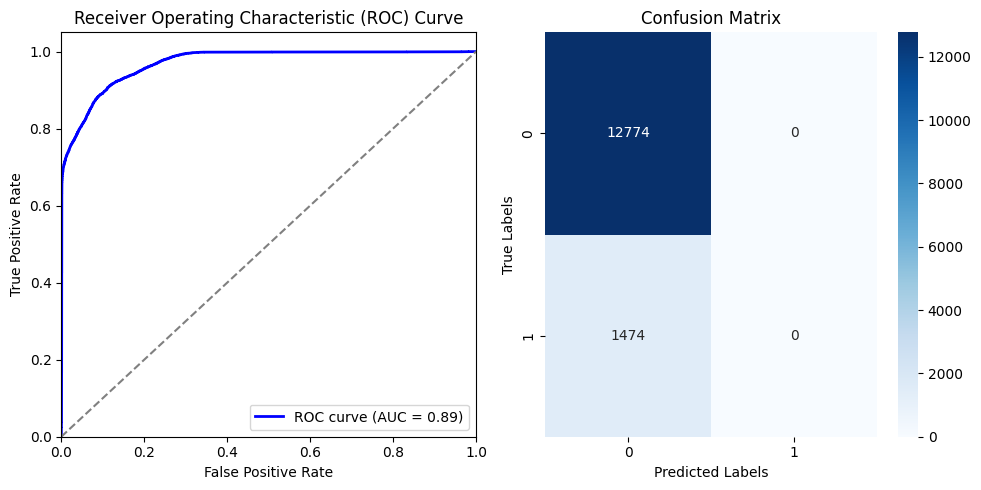

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict probabilities for the positive class (class 1)
y_pred_probs = model.predict(X_test)

# Binarize the true labels and predicted probabilities
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred_classes, classes=np.unique(y_test))

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
roc_auc = roc_auc_score(y_test_bin, y_pred_probs)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Calculate Equal Error Rate (EER)
eer_threshold = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer = 1. - interp1d(fpr, tpr)(eer_threshold)

print("Equal Error Rate (EER): {:.2f}%".format(eer * 100))

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

# Save the model in native Keras format
model.save("audio_classifier.keras")

In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/audio_classifier.keras')

# Preprocess random audio
def preprocess_audio(audio_file, sample_rate=16000, duration=5, n_mels=128, max_time_steps=109):
    audio, _ = librosa.load(audio_file, sr=sample_rate, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    return mel_spectrogram

# Make predictions
def predict_audio(model, audio_file):
    preprocessed_audio = preprocess_audio(audio_file)
    preprocessed_audio = np.expand_dims(preprocessed_audio, axis=0)  # Add batch dimension
    with tf.device('/CPU:0'):
        prediction = model.predict(preprocessed_audio)
    return prediction

# Path to your random audio file
random_audio_file = '/content/PA/PA/ASVspoof2019_PA_train/flac/PA_T_0000006.flac'

# Get predictions
prediction = predict_audio(model, random_audio_file)

# Interpret the prediction
if np.argmax(prediction) == 0:
    print("The audio is predicted to be SPOOF")
else:
    print("The audio is predicted to be bonafide.")

1/1 [==============================] - 1s 671ms/step
The audio is predicted to be SPOOF
